## Analysing temperature impacts from anesthesic interventions

Here we create the following scenarios, plotting the temperature impacts:

### Individual intervention types:
To more easily attribute the warming effects of the different components of the status quo experiment (see paper_plots notebook) we create two additional experiments where only the individual components are included: HFE-236ea2, HFE-347mmz1, HCFE-235da2, Halon-2311 and TIVA-associated CO2.




In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr

from fair import FAIR
from fair.io import read_properties
from fair.interface import fill
from fair.io import read_properties
from fair.interface import initialise

# Base scenario to run simulations
scenario_to_compare = "ssp245"

In [2]:
# First, run the base SSP scenario so we have a temperature baseline we can compare against

# Run twin experiment, but without anesthesics
f_no_anesthesics = FAIR()
f_no_anesthesics.define_time(1750, 2500, 1)
scenarios = [scenario_to_compare]
f_no_anesthesics.define_scenarios(scenarios)
fair_params_1_4_0 = '../data/fair-calibration/calibrated_constrained_parameters_1.4.0_plus_anaesthesics.csv'
df_configs = pd.read_csv(fair_params_1_4_0, index_col=0)#[400:500]
configs = df_configs.index  # label for the "config" axis
f_no_anesthesics.define_configs(configs)
species_no_anaesthesics, properties_no_anaesthesics = read_properties("../data/fair-calibration/species_configs_properties_1.4.0_original.csv")
f_no_anesthesics.define_species(species_no_anaesthesics, properties_no_anaesthesics)
f_no_anesthesics.allocate()
f_no_anesthesics.fill_from_csv(
    forcing_file='../data/forcing/volcanic_solar.csv',
)
da_emissions = xr.load_dataarray("../data/emissions/ssp_emissions_1750-2500.nc")
output_ensemble_size = len(configs)
da = da_emissions.loc[dict(config="unspecified", scenario=scenarios)]
fe = da.expand_dims(dim=["config"], axis=(2))
f_no_anesthesics.emissions = fe.drop_vars(("config")) * np.ones((1, 1, output_ensemble_size, 1))
f_no_anesthesics.fill_species_configs("../data/fair-calibration/species_configs_properties_1.4.0_anesthesics.csv")
initialise(f_no_anesthesics.concentration, f_no_anesthesics.species_configs["baseline_concentration"])
initialise(f_no_anesthesics.forcing, 0)
initialise(f_no_anesthesics.temperature, 0)
initialise(f_no_anesthesics.cumulative_emissions, 0)
initialise(f_no_anesthesics.airborne_emissions, 0)
f_no_anesthesics.override_defaults('../data/fair-calibration/calibrated_constrained_parameters_1.4.0.csv')

f_no_anesthesics.run()

# To be able to run other simulations and not run out of memory, copy the temperature data that we are interested in and delete the simulation object
f_no_anesthesics_temperature = f_no_anesthesics.temperature[:,:,:,0].copy(deep=True).loc[dict(scenario=scenario_to_compare)]
del f_no_anesthesics

Running 841 projections in parallel:   0%|          | 0/750 [00:00<?, ?timesteps/s]

In [19]:
# First experiment: History + status quo as defined in ../data/emissions/anesthesics_gas_emissions(based on Talbot NO adjustment).csv

f_status_quo = FAIR()
f_status_quo.define_time(1750, 2500, 1)

# scenarios = ['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp434', 'ssp460', 'ssp534-over', 'ssp585']
scenarios = [scenario_to_compare]
f_status_quo.define_scenarios(scenarios)

# Old simple configs
# configs = ["high", "central", "low"]
# f.define_configs(configs)

fair_params_1_4_0 = '../data/fair-calibration/calibrated_constrained_parameters_1.4.0_plus_anaesthesics.csv'
df_configs = pd.read_csv(fair_params_1_4_0, index_col=0)#[400:500]
configs = df_configs.index  # label for the "config" axis
f_status_quo.define_configs(configs)

species, properties = read_properties("../data/fair-calibration/species_configs_properties_1.4.0_anesthesics.csv")
f_status_quo.define_species(species, properties)

f_status_quo.allocate()

f_status_quo.fill_from_csv(
    forcing_file='../data/forcing/volcanic_solar.csv',
)

# I was lazy and didn't convert emissions to CSV, so use the old clunky method of importing from netCDF
# this is from calibration-1.4.0
da_emissions = xr.load_dataarray("../data/emissions/ssp_emissions_1750-2500_anesthesics.nc")
output_ensemble_size = len(configs)
da = da_emissions.loc[dict(config="unspecified", scenario=scenarios)] # select which scenarios we are going to run from the emissions data
fe = da.expand_dims(dim=["config"], axis=(2)) #  Create an object with those scenarios for each possible configuration
f_status_quo.emissions = fe.drop_vars(("config")) * np.ones((1, 1, output_ensemble_size, 1))

# Fill anesthesics
anesthesics_df = pd.read_csv("../data/emissions/anesthesics_gas_emissions(based on Talbot NO adjustment).csv")

# Prepare the new emissions
species1_df = anesthesics_df[
    (anesthesics_df["Variable"] == "HFE-236ea2") &
    (anesthesics_df["Scenario"].isin(scenarios))
]
emissions_1_status_quo = species1_df.loc[:, '1751':'2500'].astype(float).values.T
emissions_1_status_quo = emissions_1_status_quo[:, :, np.newaxis]
emissions_1_status_quo = np.repeat(emissions_1_status_quo, len(configs), axis=2)

species2_df = anesthesics_df[
    (anesthesics_df["Variable"] == "HFE-347mmz1") &
    (anesthesics_df["Scenario"].isin(scenarios))
]
emissions_2_status_quo = species2_df.loc[:, '1751':'2500'].astype(float).values.T
emissions_2_status_quo = emissions_2_status_quo[:, :, np.newaxis]
emissions_2_status_quo = np.repeat(emissions_2_status_quo, len(configs), axis=2)

species3_df = anesthesics_df[
    (anesthesics_df["Variable"] == "HCFE-235da2") &
    (anesthesics_df["Scenario"].isin(scenarios))
]
emissions_3_status_quo = species3_df.loc[:, '1751':'2500'].astype(float).values.T
emissions_3_status_quo = emissions_3_status_quo[:, :, np.newaxis]
emissions_3_status_quo = np.repeat(emissions_3_status_quo, len(configs), axis=2)

species4_df = anesthesics_df[
    (anesthesics_df["Variable"] == "Halon-2311") &
    (anesthesics_df["Scenario"].isin(scenarios))
]
emissions_4_status_quo = species4_df.loc[:, '1751':'2500'].astype(float).values.T
emissions_4_status_quo = emissions_4_status_quo[:, :, np.newaxis]
emissions_4_status_quo = np.repeat(emissions_4_status_quo, len(configs), axis=2)

fill(f_status_quo.emissions, emissions_1_status_quo, specie="HFE-236ea2")
fill(f_status_quo.emissions, emissions_2_status_quo, specie="HFE-347mmz1")
fill(f_status_quo.emissions, emissions_3_status_quo, specie="HCFE-235da2")
fill(f_status_quo.emissions, emissions_4_status_quo, specie="Halon-2311")

# Also include historical emissions associated with TIVA interventions for the last 25 years
# 40.000.000 interventions per annum * 0.56 kg of plastic per interventions * 3.14 kg CO2 from incinerated kg of plastic * 1-12 to convert to GtCO2 = 7.0336e-5 GtCO2
TIVA_emissions_status_quo = np.zeros(750)
# Linear increase from 0 → 50 million interventions over 25 years
interventions_linear_status_quo = np.linspace(0, 50_000_000, 25)
TIVA_emissions_status_quo[250:275] = interventions_linear_status_quo * 0.56 * 3.14 * 1e-12

# From then onwards, assume that the same number of interventions are performed with TIVA
TIVA_emissions_status_quo[275:] = interventions_linear_status_quo[-1] * 0.56 * 3.14 * 1e-12

f_status_quo.emissions.loc[dict(specie='CO2 FFI')] = f_status_quo.emissions.loc[dict(specie='CO2 FFI')] + TIVA_emissions_status_quo[:, np.newaxis, np.newaxis]

f_status_quo.fill_species_configs("../data/fair-calibration/species_configs_properties_1.4.0_anesthesics.csv")

# initialising 
initialise(f_status_quo.concentration, f_status_quo.species_configs["baseline_concentration"])
initialise(f_status_quo.forcing, 0)
initialise(f_status_quo.temperature, 0)
initialise(f_status_quo.cumulative_emissions, 0)
initialise(f_status_quo.airborne_emissions, 0)


f_status_quo.override_defaults('../data/fair-calibration/calibrated_constrained_parameters_1.4.0_plus_anaesthesics.csv')

f_status_quo.run()

# To be able to run other simulations and not run out of memory, copy the temperature data that we are interested in and delete the simulation object
f_status_quo_temperature = f_status_quo.temperature[:,:,:,0].copy(deep=True).loc[dict(scenario=scenario_to_compare)]
del f_status_quo

Running 841 projections in parallel:   0%|          | 0/750 [00:00<?, ?timesteps/s]

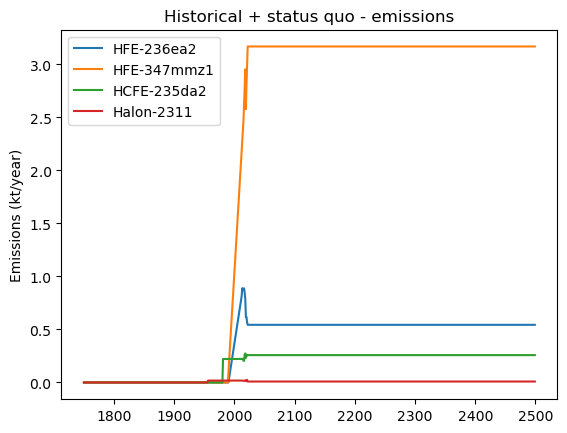

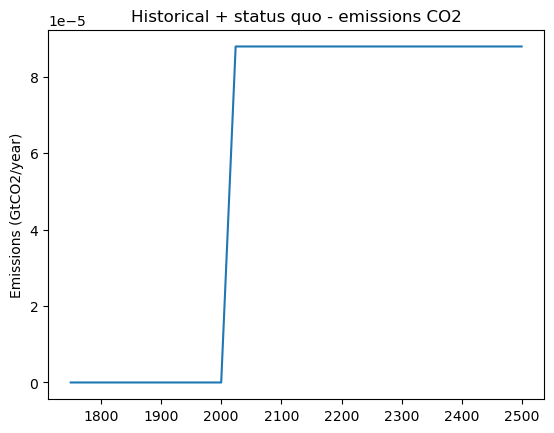

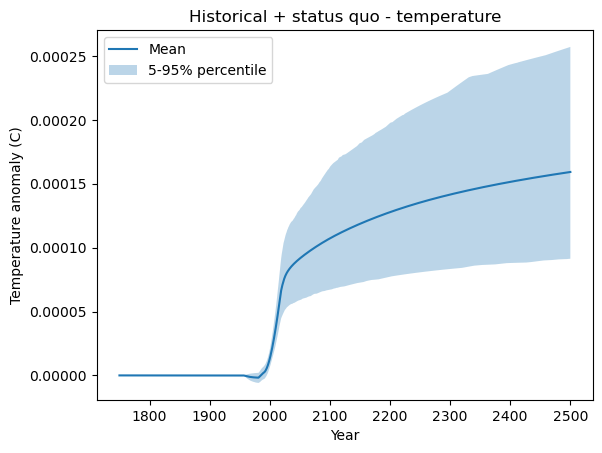

In [20]:
# First experiment plots: History + status quo as defined in ../data/emissions/anesthesics_gas_emissions(based on Talbot NO adjustment).csv

mean_f_status_quo_temperature = (f_status_quo_temperature - f_no_anesthesics_temperature).mean(dim='config')
p05_f_status_quo_temperature = (f_status_quo_temperature - f_no_anesthesics_temperature).quantile(0.05, dim='config')
p95_f_status_quo_temperature = (f_status_quo_temperature - f_no_anesthesics_temperature).quantile(0.95, dim='config')

# For diagnosis purposes, just plot these emissions timeseries
timebounds = np.arange(1750,2500,1)
timebounds_1 = np.arange(1750,2501,1)
plt.plot(timebounds, emissions_1_status_quo[:, 0, 0], label="HFE-236ea2")
plt.plot(timebounds, emissions_2_status_quo[:, 0, 0], label="HFE-347mmz1")
plt.plot(timebounds, emissions_3_status_quo[:, 0, 0], label="HCFE-235da2")
plt.plot(timebounds, emissions_4_status_quo[:, 0, 0], label="Halon-2311")
plt.title('Historical + status quo - emissions')
plt.ylabel('Emissions (kt/year)')
plt.legend()
plt.show()

plt.plot(timebounds, TIVA_emissions_status_quo)
plt.title('Historical + status quo - emissions CO2')
plt.ylabel('Emissions (GtCO2/year)')
plt.show()

# Plot the mean with a shaded area for 5-95 percentile
plt.plot(timebounds_1, mean_f_status_quo_temperature, label='Mean')
plt.fill_between(timebounds_1, p05_f_status_quo_temperature, p95_f_status_quo_temperature, alpha=0.3, label='5-95% percentile')

plt.title('Historical + status quo - temperature')
plt.xlabel('Year')
plt.ylabel('Temperature anomaly (C)')
plt.legend()
plt.show()


In [ ]:
# First experiment: History + status quo as defined in ../data/emissions/anesthesics_gas_emissions(based on Talbot NO adjustment).csv
# Contribution from HFE-236ea2

f_status_q_desflurane = FAIR()
f_status_q_desflurane.define_time(1750, 2500, 1)

# scenarios = ['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp434', 'ssp460', 'ssp534-over', 'ssp585']
scenarios = [scenario_to_compare]
f_status_q_desflurane.define_scenarios(scenarios)

# Old simple configs
# configs = ["high", "central", "low"]
# f.define_configs(configs)

fair_params_1_4_0 = '../data/fair-calibration/calibrated_constrained_parameters_1.4.0_plus_anaesthesics.csv'
df_configs = pd.read_csv(fair_params_1_4_0, index_col=0)#[400:500]
configs = df_configs.index  # label for the "config" axis
f_status_q_desflurane.define_configs(configs)

species, properties = read_properties("../data/fair-calibration/species_configs_properties_1.4.0_anesthesics.csv")
f_status_q_desflurane.define_species(species, properties)

f_status_q_desflurane.allocate()

f_status_q_desflurane.fill_from_csv(
    forcing_file='../data/forcing/volcanic_solar.csv',
)

# I was lazy and didn't convert emissions to CSV, so use the old clunky method of importing from netCDF
# this is from calibration-1.4.0
da_emissions = xr.load_dataarray("../data/emissions/ssp_emissions_1750-2500_anesthesics.nc")
output_ensemble_size = len(configs)
da = da_emissions.loc[dict(config="unspecified", scenario=scenarios)] # select which scenarios we are going to run from the emissions data
fe = da.expand_dims(dim=["config"], axis=(2)) #  Create an object with those scenarios for each possible configuration
f_status_q_desflurane.emissions = fe.drop_vars(("config")) * np.ones((1, 1, output_ensemble_size, 1))

# Fill anesthesics
anesthesics_df = pd.read_csv("../data/emissions/anesthesics_gas_emissions(based on Talbot NO adjustment).csv")

# Prepare the new emissions
species1_df = anesthesics_df[
    (anesthesics_df["Variable"] == "HFE-236ea2") &
    (anesthesics_df["Scenario"].isin(scenarios))
]
emissions_1_status_q_desflurane = species1_df.loc[:, '1751':'2500'].astype(float).values.T
emissions_1_status_q_desflurane = emissions_1_status_q_desflurane[:, :, np.newaxis]
emissions_1_status_q_desflurane = np.repeat(emissions_1_status_q_desflurane, len(configs), axis=2)

species2_df = anesthesics_df[
    (anesthesics_df["Variable"] == "HFE-347mmz1") &
    (anesthesics_df["Scenario"].isin(scenarios))
]
emissions_2_status_q_desflurane = species2_df.loc[:, '1751':'2500'].astype(float).values.T
emissions_2_status_q_desflurane[:, :] = 0 # Set emissions to zero
emissions_2_status_q_desflurane = emissions_2_status_q_desflurane[:, :, np.newaxis]
emissions_2_status_q_desflurane = np.repeat(emissions_2_status_q_desflurane, len(configs), axis=2)

species3_df = anesthesics_df[
    (anesthesics_df["Variable"] == "HCFE-235da2") &
    (anesthesics_df["Scenario"].isin(scenarios))
]
emissions_3_status_q_desflurane = species3_df.loc[:, '1751':'2500'].astype(float).values.T
emissions_3_status_q_desflurane[:, :] = 0 # Set emissions to zero
emissions_3_status_q_desflurane = emissions_3_status_q_desflurane[:, :, np.newaxis]
emissions_3_status_q_desflurane = np.repeat(emissions_3_status_q_desflurane, len(configs), axis=2)

species4_df = anesthesics_df[
    (anesthesics_df["Variable"] == "Halon-2311") &
    (anesthesics_df["Scenario"].isin(scenarios))
]
emissions_4_status_q_desflurane = species4_df.loc[:, '1751':'2500'].astype(float).values.T
emissions_4_status_q_desflurane[:, :] = 0 # Set emissions to zero
emissions_4_status_q_desflurane = emissions_4_status_q_desflurane[:, :, np.newaxis]
emissions_4_status_q_desflurane = np.repeat(emissions_4_status_q_desflurane, len(configs), axis=2)

fill(f_status_q_desflurane.emissions, emissions_1_status_q_desflurane, specie="HFE-236ea2")
fill(f_status_q_desflurane.emissions, emissions_2_status_q_desflurane, specie="HFE-347mmz1")
fill(f_status_q_desflurane.emissions, emissions_3_status_q_desflurane, specie="HCFE-235da2")
fill(f_status_q_desflurane.emissions, emissions_4_status_q_desflurane, specie="Halon-2311")

# Also include historical emissions associated with TIVA interventions for the last 25 years
# 40.000.000 interventions per annum * 0.56 kg of plastic per interventions * 3.14 kg CO2 from incinerated kg of plastic * 1-12 to convert to GtCO2 = 7.0336e-5 GtCO2
TIVA_emissions_status_q_desflurane = np.zeros(750)
# # Linear increase from 0 → 50 million interventions over 25 years
# interventions_linear_status_q_desflurane = np.linspace(0, 50_000_000, 25)
# TIVA_emissions_status_q_desflurane[250:275] = interventions_linear_status_q_desflurane * 0.56 * 3.14 * 1e-12

# # From then onwards, assume that the same number of interventions are performed with TIVA
# TIVA_emissions_status_q_desflurane[275:] = interventions_linear_status_q_desflurane[-1] * 0.56 * 3.14 * 1e-12

f_status_q_desflurane.emissions.loc[dict(specie='CO2 FFI')] = f_status_q_desflurane.emissions.loc[dict(specie='CO2 FFI')] + TIVA_emissions_status_q_desflurane[:, np.newaxis, np.newaxis]

f_status_q_desflurane.fill_species_configs("../data/fair-calibration/species_configs_properties_1.4.0_anesthesics.csv")

# initialising 
initialise(f_status_q_desflurane.concentration, f_status_q_desflurane.species_configs["baseline_concentration"])
initialise(f_status_q_desflurane.forcing, 0)
initialise(f_status_q_desflurane.temperature, 0)
initialise(f_status_q_desflurane.cumulative_emissions, 0)
initialise(f_status_q_desflurane.airborne_emissions, 0)


f_status_q_desflurane.override_defaults('../data/fair-calibration/calibrated_constrained_parameters_1.4.0_plus_anaesthesics.csv')

f_status_q_desflurane.run()

# To be able to run other simulations and not run out of memory, copy the temperature data that we are interested in and delete the simulation object
f_status_q_desflurane_temperature = f_status_q_desflurane.temperature[:,:,:,0].copy(deep=True).loc[dict(scenario=scenario_to_compare)]
del f_status_q_desflurane

Running 841 projections in parallel:   0%|          | 0/750 [00:00<?, ?timesteps/s]

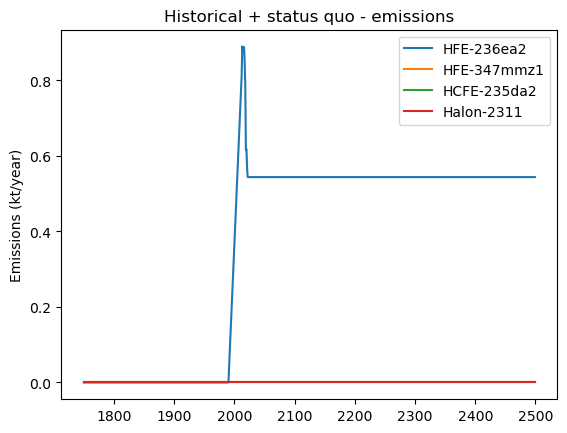

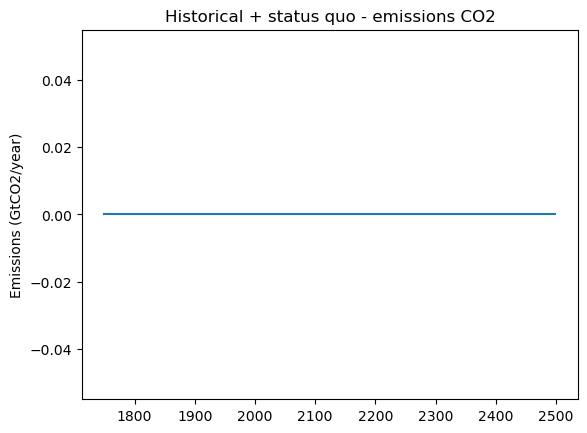

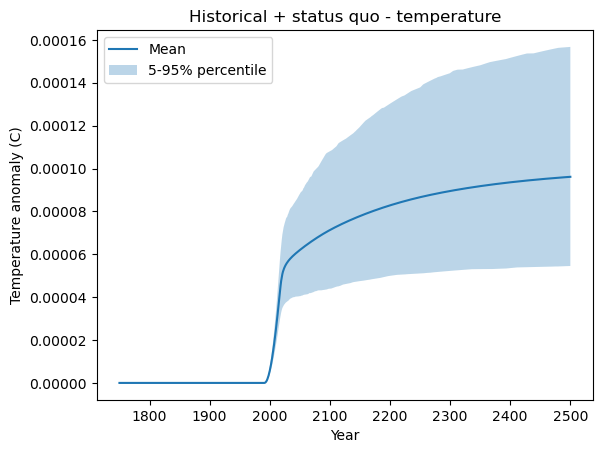

In [10]:
# First experiment plots: History + status quo as defined in ../data/emissions/anesthesics_gas_emissions(based on Talbot NO adjustment).csv

mean_f_status_q_desflurane_temperature = (f_status_q_desflurane_temperature - f_no_anesthesics_temperature).mean(dim='config')
p05_f_status_q_desflurane_temperature = (f_status_q_desflurane_temperature - f_no_anesthesics_temperature).quantile(0.05, dim='config')
p95_f_status_q_desflurane_temperature = (f_status_q_desflurane_temperature - f_no_anesthesics_temperature).quantile(0.95, dim='config')

# For diagnosis purposes, just plot these emissions timeseries
timebounds = np.arange(1750,2500,1)
timebounds_1 = np.arange(1750,2501,1)
plt.plot(timebounds, emissions_1_status_q_desflurane[:, 0, 0], label="HFE-236ea2")
plt.plot(timebounds, emissions_2_status_q_desflurane[:, 0, 0], label="HFE-347mmz1")
plt.plot(timebounds, emissions_3_status_q_desflurane[:, 0, 0], label="HCFE-235da2")
plt.plot(timebounds, emissions_4_status_q_desflurane[:, 0, 0], label="Halon-2311")
plt.title('Historical + status quo - emissions')
plt.ylabel('Emissions (kt/year)')
plt.legend()
plt.show()

plt.plot(timebounds, TIVA_emissions_status_q_desflurane)
plt.title('Historical + status quo - emissions CO2')
plt.ylabel('Emissions (GtCO2/year)')
plt.show()

# Plot the mean with a shaded area for 5-95 percentile
plt.plot(timebounds_1, mean_f_status_q_desflurane_temperature, label='Mean')
plt.fill_between(timebounds_1, p05_f_status_q_desflurane_temperature, p95_f_status_q_desflurane_temperature, alpha=0.3, label='5-95% percentile')

plt.title('Historical + status quo - temperature')
plt.xlabel('Year')
plt.ylabel('Temperature anomaly (C)')
plt.legend()
plt.show()


In [11]:
# First experiment: History + status quo as defined in ../data/emissions/anesthesics_gas_emissions(based on Talbot NO adjustment).csv
# Contribution from HFE-347mmz1

f_status_q_sevo = FAIR()
f_status_q_sevo.define_time(1750, 2500, 1)

# scenarios = ['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp434', 'ssp460', 'ssp534-over', 'ssp585']
scenarios = [scenario_to_compare]
f_status_q_sevo.define_scenarios(scenarios)

# Old simple configs
# configs = ["high", "central", "low"]
# f.define_configs(configs)

fair_params_1_4_0 = '../data/fair-calibration/calibrated_constrained_parameters_1.4.0_plus_anaesthesics.csv'
df_configs = pd.read_csv(fair_params_1_4_0, index_col=0)#[400:500]
configs = df_configs.index  # label for the "config" axis
f_status_q_sevo.define_configs(configs)

species, properties = read_properties("../data/fair-calibration/species_configs_properties_1.4.0_anesthesics.csv")
f_status_q_sevo.define_species(species, properties)

f_status_q_sevo.allocate()

f_status_q_sevo.fill_from_csv(
    forcing_file='../data/forcing/volcanic_solar.csv',
)

# I was lazy and didn't convert emissions to CSV, so use the old clunky method of importing from netCDF
# this is from calibration-1.4.0
da_emissions = xr.load_dataarray("../data/emissions/ssp_emissions_1750-2500_anesthesics.nc")
output_ensemble_size = len(configs)
da = da_emissions.loc[dict(config="unspecified", scenario=scenarios)] # select which scenarios we are going to run from the emissions data
fe = da.expand_dims(dim=["config"], axis=(2)) #  Create an object with those scenarios for each possible configuration
f_status_q_sevo.emissions = fe.drop_vars(("config")) * np.ones((1, 1, output_ensemble_size, 1))

# Fill anesthesics
anesthesics_df = pd.read_csv("../data/emissions/anesthesics_gas_emissions(based on Talbot NO adjustment).csv")

# Prepare the new emissions
species1_df = anesthesics_df[
    (anesthesics_df["Variable"] == "HFE-236ea2") &
    (anesthesics_df["Scenario"].isin(scenarios))
]
emissions_1_status_q_sevo = species1_df.loc[:, '1751':'2500'].astype(float).values.T
emissions_1_status_q_sevo[:, :] = 0 # Set emissions to zero
emissions_1_status_q_sevo = emissions_1_status_q_sevo[:, :, np.newaxis]
emissions_1_status_q_sevo = np.repeat(emissions_1_status_q_sevo, len(configs), axis=2)

species2_df = anesthesics_df[
    (anesthesics_df["Variable"] == "HFE-347mmz1") &
    (anesthesics_df["Scenario"].isin(scenarios))
]
emissions_2_status_q_sevo = species2_df.loc[:, '1751':'2500'].astype(float).values.T
emissions_2_status_q_sevo = emissions_2_status_q_sevo[:, :, np.newaxis]
emissions_2_status_q_sevo = np.repeat(emissions_2_status_q_sevo, len(configs), axis=2)

species3_df = anesthesics_df[
    (anesthesics_df["Variable"] == "HCFE-235da2") &
    (anesthesics_df["Scenario"].isin(scenarios))
]
emissions_3_status_q_sevo = species3_df.loc[:, '1751':'2500'].astype(float).values.T
emissions_3_status_q_sevo[:, :] = 0 # Set emissions to zero
emissions_3_status_q_sevo = emissions_3_status_q_sevo[:, :, np.newaxis]
emissions_3_status_q_sevo = np.repeat(emissions_3_status_q_sevo, len(configs), axis=2)

species4_df = anesthesics_df[
    (anesthesics_df["Variable"] == "Halon-2311") &
    (anesthesics_df["Scenario"].isin(scenarios))
]
emissions_4_status_q_sevo = species4_df.loc[:, '1751':'2500'].astype(float).values.T
emissions_4_status_q_sevo[:, :] = 0 # Set emissions to zero
emissions_4_status_q_sevo = emissions_4_status_q_sevo[:, :, np.newaxis]
emissions_4_status_q_sevo = np.repeat(emissions_4_status_q_sevo, len(configs), axis=2)

fill(f_status_q_sevo.emissions, emissions_1_status_q_sevo, specie="HFE-236ea2")
fill(f_status_q_sevo.emissions, emissions_2_status_q_sevo, specie="HFE-347mmz1")
fill(f_status_q_sevo.emissions, emissions_3_status_q_sevo, specie="HCFE-235da2")
fill(f_status_q_sevo.emissions, emissions_4_status_q_sevo, specie="Halon-2311")

# Also include historical emissions associated with TIVA interventions for the last 25 years
# 40.000.000 interventions per annum * 0.56 kg of plastic per interventions * 3.14 kg CO2 from incinerated kg of plastic * 1-12 to convert to GtCO2 = 7.0336e-5 GtCO2
TIVA_emissions_status_q_sevo = np.zeros(750)
# # Linear increase from 0 → 50 million interventions over 25 years
# interventions_linear_status_q_sevo = np.linspace(0, 50_000_000, 25)
# TIVA_emissions_status_q_sevo[250:275] = interventions_linear_status_q_sevo * 0.56 * 3.14 * 1e-12

# # From then onwards, assume that the same number of interventions are performed with TIVA
# TIVA_emissions_status_q_sevo[275:] = interventions_linear_status_q_sevo[-1] * 0.56 * 3.14 * 1e-12

# f_status_q_sevo.emissions.loc[dict(specie='CO2 FFI')] = f_status_q_sevo.emissions.loc[dict(specie='CO2 FFI')] + TIVA_emissions_status_q_sevo[:, np.newaxis, np.newaxis]

f_status_q_sevo.fill_species_configs("../data/fair-calibration/species_configs_properties_1.4.0_anesthesics.csv")

# initialising 
initialise(f_status_q_sevo.concentration, f_status_q_sevo.species_configs["baseline_concentration"])
initialise(f_status_q_sevo.forcing, 0)
initialise(f_status_q_sevo.temperature, 0)
initialise(f_status_q_sevo.cumulative_emissions, 0)
initialise(f_status_q_sevo.airborne_emissions, 0)


f_status_q_sevo.override_defaults('../data/fair-calibration/calibrated_constrained_parameters_1.4.0_plus_anaesthesics.csv')

f_status_q_sevo.run()

# To be able to run other simulations and not run out of memory, copy the temperature data that we are interested in and delete the simulation object
f_status_q_sevo_temperature = f_status_q_sevo.temperature[:,:,:,0].copy(deep=True).loc[dict(scenario=scenario_to_compare)]
del f_status_q_sevo

Running 841 projections in parallel:   0%|          | 0/750 [00:00<?, ?timesteps/s]

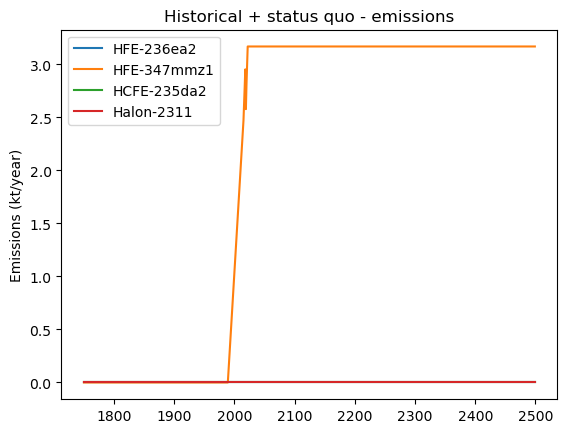

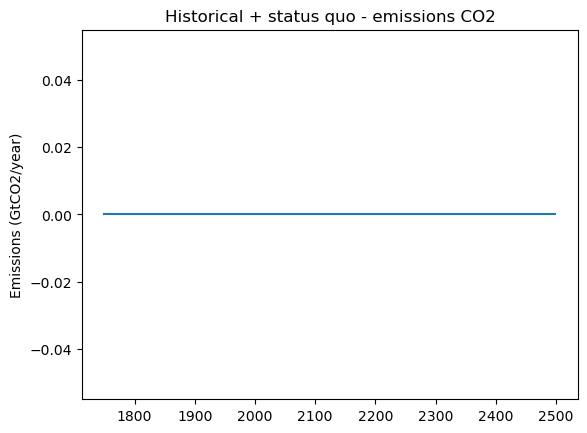

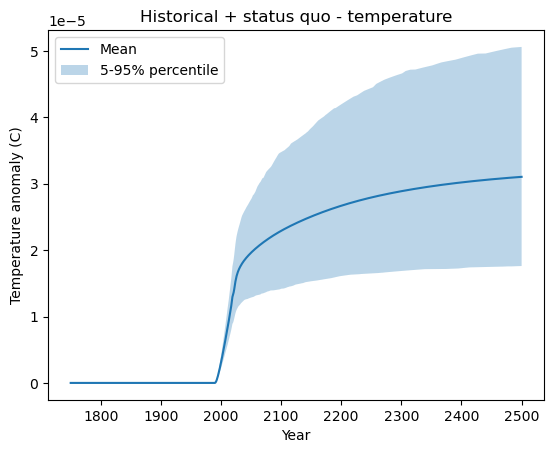

In [12]:
# First experiment plots: History + status quo as defined in ../data/emissions/anesthesics_gas_emissions(based on Talbot NO adjustment).csv

mean_f_status_q_sevo_temperature = (f_status_q_sevo_temperature - f_no_anesthesics_temperature).mean(dim='config')
p05_f_status_q_sevo_temperature = (f_status_q_sevo_temperature - f_no_anesthesics_temperature).quantile(0.05, dim='config')
p95_f_status_q_sevo_temperature = (f_status_q_sevo_temperature - f_no_anesthesics_temperature).quantile(0.95, dim='config')

# For diagnosis purposes, just plot these emissions timeseries
timebounds = np.arange(1750,2500,1)
timebounds_1 = np.arange(1750,2501,1)
plt.plot(timebounds, emissions_1_status_q_sevo[:, 0, 0], label="HFE-236ea2")
plt.plot(timebounds, emissions_2_status_q_sevo[:, 0, 0], label="HFE-347mmz1")
plt.plot(timebounds, emissions_3_status_q_sevo[:, 0, 0], label="HCFE-235da2")
plt.plot(timebounds, emissions_4_status_q_sevo[:, 0, 0], label="Halon-2311")
plt.title('Historical + status quo - emissions')
plt.ylabel('Emissions (kt/year)')
plt.legend()
plt.show()

plt.plot(timebounds, TIVA_emissions_status_q_sevo)
plt.title('Historical + status quo - emissions CO2')
plt.ylabel('Emissions (GtCO2/year)')
plt.show()

# Plot the mean with a shaded area for 5-95 percentile
plt.plot(timebounds_1, mean_f_status_q_sevo_temperature, label='Mean')
plt.fill_between(timebounds_1, p05_f_status_q_sevo_temperature, p95_f_status_q_sevo_temperature, alpha=0.3, label='5-95% percentile')

plt.title('Historical + status quo - temperature')
plt.xlabel('Year')
plt.ylabel('Temperature anomaly (C)')
plt.legend()
plt.show()


In [13]:
# First experiment: History + status quo as defined in ../data/emissions/anesthesics_gas_emissions(based on Talbot NO adjustment).csv
# Contribution from HCFE-235da2

f_status_q_iso = FAIR()
f_status_q_iso.define_time(1750, 2500, 1)

# scenarios = ['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp434', 'ssp460', 'ssp534-over', 'ssp585']
scenarios = [scenario_to_compare]
f_status_q_iso.define_scenarios(scenarios)

# Old simple configs
# configs = ["high", "central", "low"]
# f.define_configs(configs)

fair_params_1_4_0 = '../data/fair-calibration/calibrated_constrained_parameters_1.4.0_plus_anaesthesics.csv'
df_configs = pd.read_csv(fair_params_1_4_0, index_col=0)#[400:500]
configs = df_configs.index  # label for the "config" axis
f_status_q_iso.define_configs(configs)

species, properties = read_properties("../data/fair-calibration/species_configs_properties_1.4.0_anesthesics.csv")
f_status_q_iso.define_species(species, properties)

f_status_q_iso.allocate()

f_status_q_iso.fill_from_csv(
    forcing_file='../data/forcing/volcanic_solar.csv',
)

# I was lazy and didn't convert emissions to CSV, so use the old clunky method of importing from netCDF
# this is from calibration-1.4.0
da_emissions = xr.load_dataarray("../data/emissions/ssp_emissions_1750-2500_anesthesics.nc")
output_ensemble_size = len(configs)
da = da_emissions.loc[dict(config="unspecified", scenario=scenarios)] # select which scenarios we are going to run from the emissions data
fe = da.expand_dims(dim=["config"], axis=(2)) #  Create an object with those scenarios for each possible configuration
f_status_q_iso.emissions = fe.drop_vars(("config")) * np.ones((1, 1, output_ensemble_size, 1))

# Fill anesthesics
anesthesics_df = pd.read_csv("../data/emissions/anesthesics_gas_emissions(based on Talbot NO adjustment).csv")

# Prepare the new emissions
species1_df = anesthesics_df[
    (anesthesics_df["Variable"] == "HFE-236ea2") &
    (anesthesics_df["Scenario"].isin(scenarios))
]
emissions_1_status_q_iso = species1_df.loc[:, '1751':'2500'].astype(float).values.T
emissions_1_status_q_iso[:, :] = 0 # Set emissions to zero
emissions_1_status_q_iso = emissions_1_status_q_iso[:, :, np.newaxis]
emissions_1_status_q_iso = np.repeat(emissions_1_status_q_iso, len(configs), axis=2)

species2_df = anesthesics_df[
    (anesthesics_df["Variable"] == "HFE-347mmz1") &
    (anesthesics_df["Scenario"].isin(scenarios))
]
emissions_2_status_q_iso = species2_df.loc[:, '1751':'2500'].astype(float).values.T
emissions_2_status_q_iso[:, :] = 0 # Set emissions to zero
emissions_2_status_q_iso = emissions_2_status_q_iso[:, :, np.newaxis]
emissions_2_status_q_iso = np.repeat(emissions_2_status_q_iso, len(configs), axis=2)

species3_df = anesthesics_df[
    (anesthesics_df["Variable"] == "HCFE-235da2") &
    (anesthesics_df["Scenario"].isin(scenarios))
]
emissions_3_status_q_iso = species3_df.loc[:, '1751':'2500'].astype(float).values.T
emissions_3_status_q_iso = emissions_3_status_q_iso[:, :, np.newaxis]
emissions_3_status_q_iso = np.repeat(emissions_3_status_q_iso, len(configs), axis=2)

species4_df = anesthesics_df[
    (anesthesics_df["Variable"] == "Halon-2311") &
    (anesthesics_df["Scenario"].isin(scenarios))
]
emissions_4_status_q_iso = species4_df.loc[:, '1751':'2500'].astype(float).values.T
emissions_4_status_q_iso[:, :] = 0 # Set emissions to zero
emissions_4_status_q_iso = emissions_4_status_q_iso[:, :, np.newaxis]
emissions_4_status_q_iso = np.repeat(emissions_4_status_q_iso, len(configs), axis=2)

fill(f_status_q_iso.emissions, emissions_1_status_q_iso, specie="HFE-236ea2")
fill(f_status_q_iso.emissions, emissions_2_status_q_iso, specie="HFE-347mmz1")
fill(f_status_q_iso.emissions, emissions_3_status_q_iso, specie="HCFE-235da2")
fill(f_status_q_iso.emissions, emissions_4_status_q_iso, specie="Halon-2311")

# Also include historical emissions associated with TIVA interventions for the last 25 years
# 40.000.000 interventions per annum * 0.56 kg of plastic per interventions * 3.14 kg CO2 from incinerated kg of plastic * 1-12 to convert to GtCO2 = 7.0336e-5 GtCO2
TIVA_emissions_status_q_iso = np.zeros(750)
# # Linear increase from 0 → 50 million interventions over 25 years
# interventions_linear_status_q_iso = np.linspace(0, 50_000_000, 25)
# TIVA_emissions_status_q_iso[250:275] = interventions_linear_status_q_iso * 0.56 * 3.14 * 1e-12

# # From then onwards, assume that the same number of interventions are performed with TIVA
# TIVA_emissions_status_q_iso[275:] = interventions_linear_status_q_iso[-1] * 0.56 * 3.14 * 1e-12

# f_status_q_iso.emissions.loc[dict(specie='CO2 FFI')] = f_status_q_iso.emissions.loc[dict(specie='CO2 FFI')] + TIVA_emissions_status_q_iso[:, np.newaxis, np.newaxis]

f_status_q_iso.fill_species_configs("../data/fair-calibration/species_configs_properties_1.4.0_anesthesics.csv")

# initialising 
initialise(f_status_q_iso.concentration, f_status_q_iso.species_configs["baseline_concentration"])
initialise(f_status_q_iso.forcing, 0)
initialise(f_status_q_iso.temperature, 0)
initialise(f_status_q_iso.cumulative_emissions, 0)
initialise(f_status_q_iso.airborne_emissions, 0)


f_status_q_iso.override_defaults('../data/fair-calibration/calibrated_constrained_parameters_1.4.0_plus_anaesthesics.csv')

f_status_q_iso.run()

# To be able to run other simulations and not run out of memory, copy the temperature data that we are interested in and delete the simulation object
f_status_q_iso_temperature = f_status_q_iso.temperature[:,:,:,0].copy(deep=True).loc[dict(scenario=scenario_to_compare)]
del f_status_q_iso

Running 841 projections in parallel:   0%|          | 0/750 [00:00<?, ?timesteps/s]

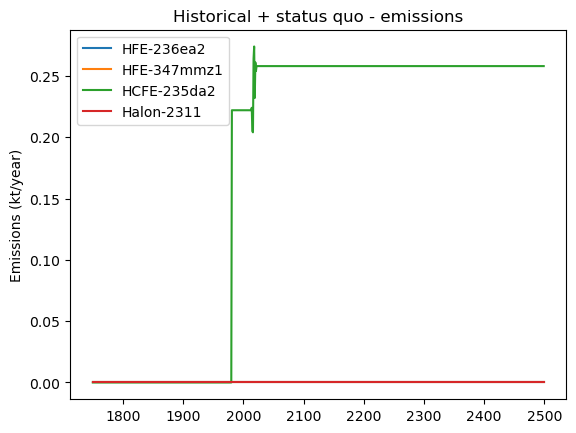

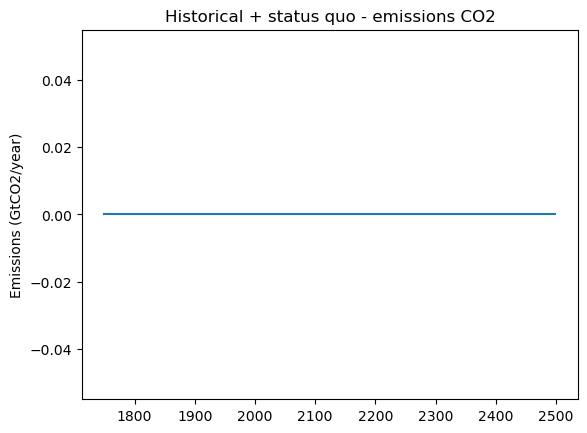

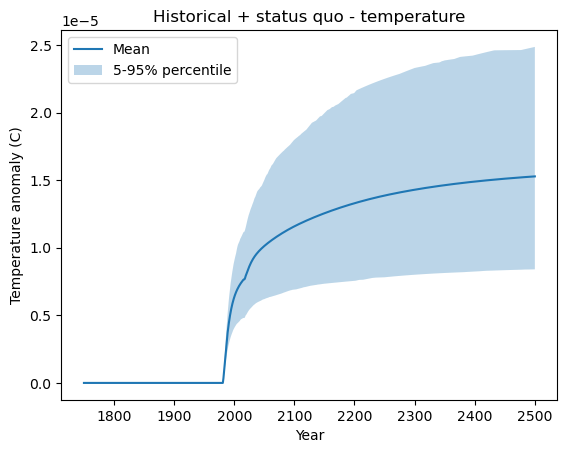

In [14]:
# First experiment plots: History + status quo as defined in ../data/emissions/anesthesics_gas_emissions(based on Talbot NO adjustment).csv

mean_f_status_q_iso_temperature = (f_status_q_iso_temperature - f_no_anesthesics_temperature).mean(dim='config')
p05_f_status_q_iso_temperature = (f_status_q_iso_temperature - f_no_anesthesics_temperature).quantile(0.05, dim='config')
p95_f_status_q_iso_temperature = (f_status_q_iso_temperature - f_no_anesthesics_temperature).quantile(0.95, dim='config')

# For diagnosis purposes, just plot these emissions timeseries
timebounds = np.arange(1750,2500,1)
timebounds_1 = np.arange(1750,2501,1)
plt.plot(timebounds, emissions_1_status_q_iso[:, 0, 0], label="HFE-236ea2")
plt.plot(timebounds, emissions_2_status_q_iso[:, 0, 0], label="HFE-347mmz1")
plt.plot(timebounds, emissions_3_status_q_iso[:, 0, 0], label="HCFE-235da2")
plt.plot(timebounds, emissions_4_status_q_iso[:, 0, 0], label="Halon-2311")
plt.title('Historical + status quo - emissions')
plt.ylabel('Emissions (kt/year)')
plt.legend()
plt.show()

plt.plot(timebounds, TIVA_emissions_status_q_iso)
plt.title('Historical + status quo - emissions CO2')
plt.ylabel('Emissions (GtCO2/year)')
plt.show()

# Plot the mean with a shaded area for 5-95 percentile
plt.plot(timebounds_1, mean_f_status_q_iso_temperature, label='Mean')
plt.fill_between(timebounds_1, p05_f_status_q_iso_temperature, p95_f_status_q_iso_temperature, alpha=0.3, label='5-95% percentile')

plt.title('Historical + status quo - temperature')
plt.xlabel('Year')
plt.ylabel('Temperature anomaly (C)')
plt.legend()
plt.show()


In [15]:
# First experiment: History + status quo as defined in ../data/emissions/anesthesics_gas_emissions(based on Talbot NO adjustment).csv
# Contribution from Halon-2311

f_status_q_halo = FAIR()
f_status_q_halo.define_time(1750, 2500, 1)

# scenarios = ['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp434', 'ssp460', 'ssp534-over', 'ssp585']
scenarios = [scenario_to_compare]
f_status_q_halo.define_scenarios(scenarios)

# Old simple configs
# configs = ["high", "central", "low"]
# f.define_configs(configs)

fair_params_1_4_0 = '../data/fair-calibration/calibrated_constrained_parameters_1.4.0_plus_anaesthesics.csv'
df_configs = pd.read_csv(fair_params_1_4_0, index_col=0)#[400:500]
configs = df_configs.index  # label for the "config" axis
f_status_q_halo.define_configs(configs)

species, properties = read_properties("../data/fair-calibration/species_configs_properties_1.4.0_anesthesics.csv")
f_status_q_halo.define_species(species, properties)

f_status_q_halo.allocate()

f_status_q_halo.fill_from_csv(
    forcing_file='../data/forcing/volcanic_solar.csv',
)

# I was lazy and didn't convert emissions to CSV, so use the old clunky method of importing from netCDF
# this is from calibration-1.4.0
da_emissions = xr.load_dataarray("../data/emissions/ssp_emissions_1750-2500_anesthesics.nc")
output_ensemble_size = len(configs)
da = da_emissions.loc[dict(config="unspecified", scenario=scenarios)] # select which scenarios we are going to run from the emissions data
fe = da.expand_dims(dim=["config"], axis=(2)) #  Create an object with those scenarios for each possible configuration
f_status_q_halo.emissions = fe.drop_vars(("config")) * np.ones((1, 1, output_ensemble_size, 1))

# Fill anesthesics
anesthesics_df = pd.read_csv("../data/emissions/anesthesics_gas_emissions(based on Talbot NO adjustment).csv")

# Prepare the new emissions
species1_df = anesthesics_df[
    (anesthesics_df["Variable"] == "HFE-236ea2") &
    (anesthesics_df["Scenario"].isin(scenarios))
]
emissions_1_status_q_halo = species1_df.loc[:, '1751':'2500'].astype(float).values.T
emissions_1_status_q_halo[:, :] = 0 # Set emissions to zero
emissions_1_status_q_halo = emissions_1_status_q_halo[:, :, np.newaxis]
emissions_1_status_q_halo = np.repeat(emissions_1_status_q_halo, len(configs), axis=2)

species2_df = anesthesics_df[
    (anesthesics_df["Variable"] == "HFE-347mmz1") &
    (anesthesics_df["Scenario"].isin(scenarios))
]
emissions_2_status_q_halo = species2_df.loc[:, '1751':'2500'].astype(float).values.T
emissions_2_status_q_halo[:, :] = 0 # Set emissions to zero
emissions_2_status_q_halo = emissions_2_status_q_halo[:, :, np.newaxis]
emissions_2_status_q_halo = np.repeat(emissions_2_status_q_halo, len(configs), axis=2)

species3_df = anesthesics_df[
    (anesthesics_df["Variable"] == "HCFE-235da2") &
    (anesthesics_df["Scenario"].isin(scenarios))
]
emissions_3_status_q_halo = species3_df.loc[:, '1751':'2500'].astype(float).values.T
emissions_3_status_q_halo[:, :] = 0 # Set emissions to zero
emissions_3_status_q_halo = emissions_3_status_q_halo[:, :, np.newaxis]
emissions_3_status_q_halo = np.repeat(emissions_3_status_q_halo, len(configs), axis=2)

species4_df = anesthesics_df[
    (anesthesics_df["Variable"] == "Halon-2311") &
    (anesthesics_df["Scenario"].isin(scenarios))
]
emissions_4_status_q_halo = species4_df.loc[:, '1751':'2500'].astype(float).values.T
emissions_4_status_q_halo = emissions_4_status_q_halo[:, :, np.newaxis]
emissions_4_status_q_halo = np.repeat(emissions_4_status_q_halo, len(configs), axis=2)

fill(f_status_q_halo.emissions, emissions_1_status_q_halo, specie="HFE-236ea2")
fill(f_status_q_halo.emissions, emissions_2_status_q_halo, specie="HFE-347mmz1")
fill(f_status_q_halo.emissions, emissions_3_status_q_halo, specie="HCFE-235da2")
fill(f_status_q_halo.emissions, emissions_4_status_q_halo, specie="Halon-2311")

# Also include historical emissions associated with TIVA interventions for the last 25 years
# 40.000.000 interventions per annum * 0.56 kg of plastic per interventions * 3.14 kg CO2 from incinerated kg of plastic * 1-12 to convert to GtCO2 = 7.0336e-5 GtCO2
TIVA_emissions_status_q_halo = np.zeros(750)
# # Linear increase from 0 → 50 million interventions over 25 years
# interventions_linear_status_q_halo = np.linspace(0, 50_000_000, 25)
# TIVA_emissions_status_q_halo[250:275] = interventions_linear_status_q_halo * 0.56 * 3.14 * 1e-12

# # From then onwards, assume that the same number of interventions are performed with TIVA
# TIVA_emissions_status_q_halo[275:] = interventions_linear_status_q_halo[-1] * 0.56 * 3.14 * 1e-12

# f_status_q_halo.emissions.loc[dict(specie='CO2 FFI')] = f_status_q_halo.emissions.loc[dict(specie='CO2 FFI')] + TIVA_emissions_status_q_halo[:, np.newaxis, np.newaxis]

f_status_q_halo.fill_species_configs("../data/fair-calibration/species_configs_properties_1.4.0_anesthesics.csv")

# initialising 
initialise(f_status_q_halo.concentration, f_status_q_halo.species_configs["baseline_concentration"])
initialise(f_status_q_halo.forcing, 0)
initialise(f_status_q_halo.temperature, 0)
initialise(f_status_q_halo.cumulative_emissions, 0)
initialise(f_status_q_halo.airborne_emissions, 0)


f_status_q_halo.override_defaults('../data/fair-calibration/calibrated_constrained_parameters_1.4.0_plus_anaesthesics.csv')

f_status_q_halo.run()

# To be able to run other simulations and not run out of memory, copy the temperature data that we are interested in and delete the simulation object
f_status_q_halo_temperature = f_status_q_halo.temperature[:,:,:,0].copy(deep=True).loc[dict(scenario=scenario_to_compare)]
del f_status_q_halo

Running 841 projections in parallel:   0%|          | 0/750 [00:00<?, ?timesteps/s]

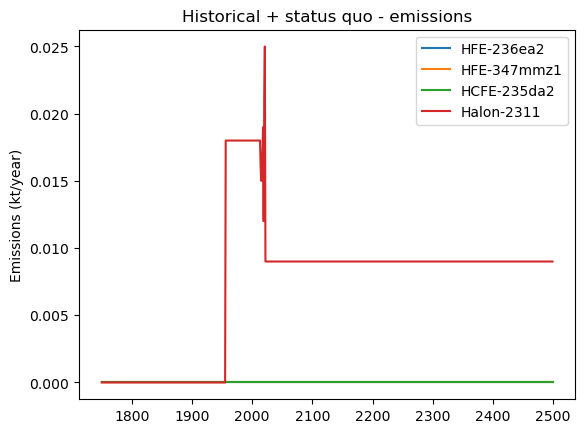

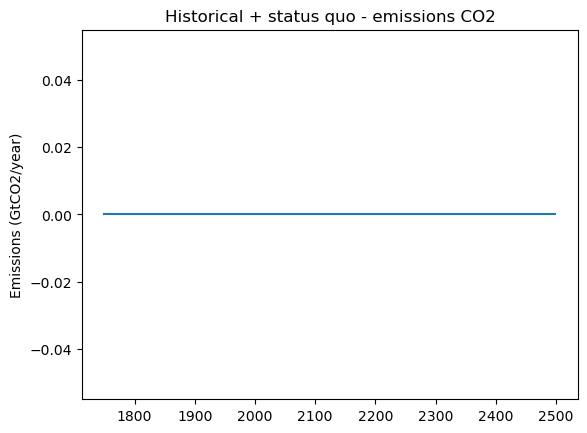

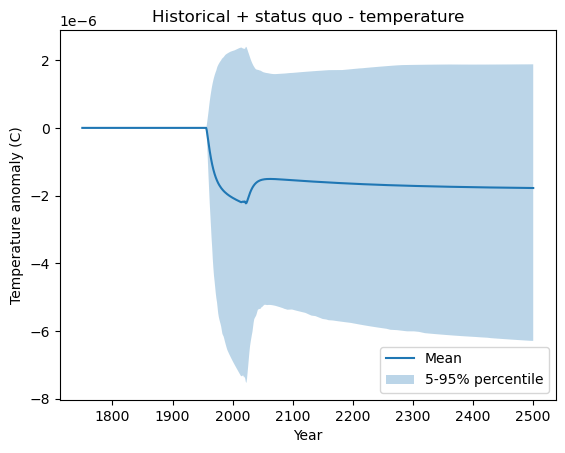

In [16]:
# First experiment plots: History + status quo as defined in ../data/emissions/anesthesics_gas_emissions(based on Talbot NO adjustment).csv

mean_f_status_q_halo_temperature = (f_status_q_halo_temperature - f_no_anesthesics_temperature).mean(dim='config')
p05_f_status_q_halo_temperature = (f_status_q_halo_temperature - f_no_anesthesics_temperature).quantile(0.05, dim='config')
p95_f_status_q_halo_temperature = (f_status_q_halo_temperature - f_no_anesthesics_temperature).quantile(0.95, dim='config')

# For diagnosis purposes, just plot these emissions timeseries
timebounds = np.arange(1750,2500,1)
timebounds_1 = np.arange(1750,2501,1)
plt.plot(timebounds, emissions_1_status_q_halo[:, 0, 0], label="HFE-236ea2")
plt.plot(timebounds, emissions_2_status_q_halo[:, 0, 0], label="HFE-347mmz1")
plt.plot(timebounds, emissions_3_status_q_halo[:, 0, 0], label="HCFE-235da2")
plt.plot(timebounds, emissions_4_status_q_halo[:, 0, 0], label="Halon-2311")
plt.title('Historical + status quo - emissions')
plt.ylabel('Emissions (kt/year)')
plt.legend()
plt.show()

plt.plot(timebounds, TIVA_emissions_status_q_halo)
plt.title('Historical + status quo - emissions CO2')
plt.ylabel('Emissions (GtCO2/year)')
plt.show()

# Plot the mean with a shaded area for 5-95 percentile
plt.plot(timebounds_1, mean_f_status_q_halo_temperature, label='Mean')
plt.fill_between(timebounds_1, p05_f_status_q_halo_temperature, p95_f_status_q_halo_temperature, alpha=0.3, label='5-95% percentile')

plt.title('Historical + status quo - temperature')
plt.xlabel('Year')
plt.ylabel('Temperature anomaly (C)')
plt.legend()
plt.show()


In [17]:
# First experiment: History + status quo as defined in ../data/emissions/anesthesics_gas_emissions(based on Talbot NO adjustment).csv

f_status_q_tiva = FAIR()
f_status_q_tiva.define_time(1750, 2500, 1)

# scenarios = ['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp434', 'ssp460', 'ssp534-over', 'ssp585']
scenarios = [scenario_to_compare]
f_status_q_tiva.define_scenarios(scenarios)

# Old simple configs
# configs = ["high", "central", "low"]
# f.define_configs(configs)

fair_params_1_4_0 = '../data/fair-calibration/calibrated_constrained_parameters_1.4.0_plus_anaesthesics.csv'
df_configs = pd.read_csv(fair_params_1_4_0, index_col=0)#[400:500]
configs = df_configs.index  # label for the "config" axis
f_status_q_tiva.define_configs(configs)

species, properties = read_properties("../data/fair-calibration/species_configs_properties_1.4.0_anesthesics.csv")
f_status_q_tiva.define_species(species, properties)

f_status_q_tiva.allocate()

f_status_q_tiva.fill_from_csv(
    forcing_file='../data/forcing/volcanic_solar.csv',
)

# I was lazy and didn't convert emissions to CSV, so use the old clunky method of importing from netCDF
# this is from calibration-1.4.0
da_emissions = xr.load_dataarray("../data/emissions/ssp_emissions_1750-2500_anesthesics.nc")
output_ensemble_size = len(configs)
da = da_emissions.loc[dict(config="unspecified", scenario=scenarios)] # select which scenarios we are going to run from the emissions data
fe = da.expand_dims(dim=["config"], axis=(2)) #  Create an object with those scenarios for each possible configuration
f_status_q_tiva.emissions = fe.drop_vars(("config")) * np.ones((1, 1, output_ensemble_size, 1))

# Fill anesthesics
anesthesics_df = pd.read_csv("../data/emissions/anesthesics_gas_emissions(based on Talbot NO adjustment).csv")

# Prepare the new emissions
species1_df = anesthesics_df[
    (anesthesics_df["Variable"] == "HFE-236ea2") &
    (anesthesics_df["Scenario"].isin(scenarios))
]
emissions_1_status_q_tiva = species1_df.loc[:, '1751':'2500'].astype(float).values.T
emissions_1_status_q_tiva[:, :] = 0 # Set emissions to zero
emissions_1_status_q_tiva = emissions_1_status_q_tiva[:, :, np.newaxis]
emissions_1_status_q_tiva = np.repeat(emissions_1_status_q_tiva, len(configs), axis=2)

species2_df = anesthesics_df[
    (anesthesics_df["Variable"] == "HFE-347mmz1") &
    (anesthesics_df["Scenario"].isin(scenarios))
]
emissions_2_status_q_tiva = species2_df.loc[:, '1751':'2500'].astype(float).values.T
emissions_2_status_q_tiva[:, :] = 0 # Set emissions to zero
emissions_2_status_q_tiva = emissions_2_status_q_tiva[:, :, np.newaxis]
emissions_2_status_q_tiva = np.repeat(emissions_2_status_q_tiva, len(configs), axis=2)

species3_df = anesthesics_df[
    (anesthesics_df["Variable"] == "HCFE-235da2") &
    (anesthesics_df["Scenario"].isin(scenarios))
]
emissions_3_status_q_tiva = species3_df.loc[:, '1751':'2500'].astype(float).values.T
emissions_3_status_q_tiva[:, :] = 0 # Set emissions to zero
emissions_3_status_q_tiva = emissions_3_status_q_tiva[:, :, np.newaxis]
emissions_3_status_q_tiva = np.repeat(emissions_3_status_q_tiva, len(configs), axis=2)

species4_df = anesthesics_df[
    (anesthesics_df["Variable"] == "Halon-2311") &
    (anesthesics_df["Scenario"].isin(scenarios))
]
emissions_4_status_q_tiva = species4_df.loc[:, '1751':'2500'].astype(float).values.T
emissions_4_status_q_tiva[:, :] = 0 # Set emissions to zero
emissions_4_status_q_tiva = emissions_4_status_q_tiva[:, :, np.newaxis]
emissions_4_status_q_tiva = np.repeat(emissions_4_status_q_tiva, len(configs), axis=2)

fill(f_status_q_tiva.emissions, emissions_1_status_q_tiva, specie="HFE-236ea2")
fill(f_status_q_tiva.emissions, emissions_2_status_q_tiva, specie="HFE-347mmz1")
fill(f_status_q_tiva.emissions, emissions_3_status_q_tiva, specie="HCFE-235da2")
fill(f_status_q_tiva.emissions, emissions_4_status_q_tiva, specie="Halon-2311")

# Also include historical emissions associated with TIVA interventions for the last 25 years
# 40.000.000 interventions per annum * 0.56 kg of plastic per interventions * 3.14 kg CO2 from incinerated kg of plastic * 1-12 to convert to GtCO2 = 7.0336e-5 GtCO2
TIVA_emissions_status_q_tiva = np.zeros(750)
# Linear increase from 0 → 50 million interventions over 25 years
interventions_linear_status_q_tiva = np.linspace(0, 50_000_000, 25)
TIVA_emissions_status_q_tiva[250:275] = interventions_linear_status_q_tiva * 0.56 * 3.14 * 1e-12

# From then onwards, assume that the same number of interventions are performed with TIVA
TIVA_emissions_status_q_tiva[275:] = interventions_linear_status_q_tiva[-1] * 0.56 * 3.14 * 1e-12

f_status_q_tiva.emissions.loc[dict(specie='CO2 FFI')] = f_status_q_tiva.emissions.loc[dict(specie='CO2 FFI')] + TIVA_emissions_status_q_tiva[:, np.newaxis, np.newaxis]

f_status_q_tiva.fill_species_configs("../data/fair-calibration/species_configs_properties_1.4.0_anesthesics.csv")

# initialising 
initialise(f_status_q_tiva.concentration, f_status_q_tiva.species_configs["baseline_concentration"])
initialise(f_status_q_tiva.forcing, 0)
initialise(f_status_q_tiva.temperature, 0)
initialise(f_status_q_tiva.cumulative_emissions, 0)
initialise(f_status_q_tiva.airborne_emissions, 0)


f_status_q_tiva.override_defaults('../data/fair-calibration/calibrated_constrained_parameters_1.4.0_plus_anaesthesics.csv')

f_status_q_tiva.run()

# To be able to run other simulations and not run out of memory, copy the temperature data that we are interested in and delete the simulation object
f_status_q_tiva_temperature = f_status_q_tiva.temperature[:,:,:,0].copy(deep=True).loc[dict(scenario=scenario_to_compare)]
del f_status_q_tiva

Running 841 projections in parallel:   0%|          | 0/750 [00:00<?, ?timesteps/s]

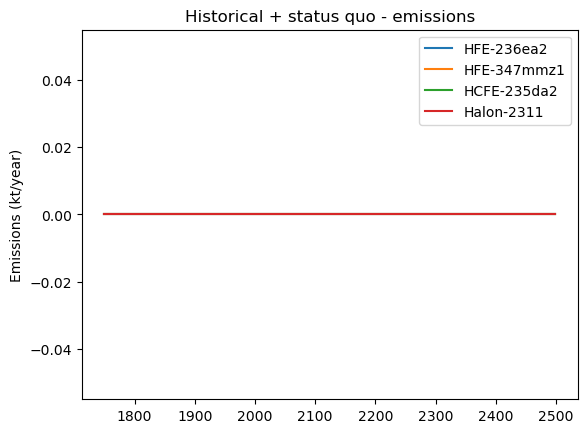

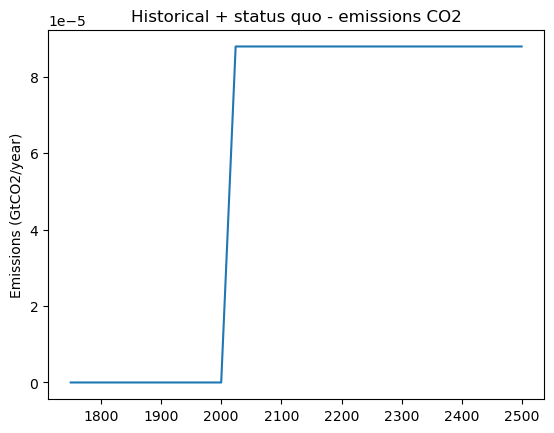

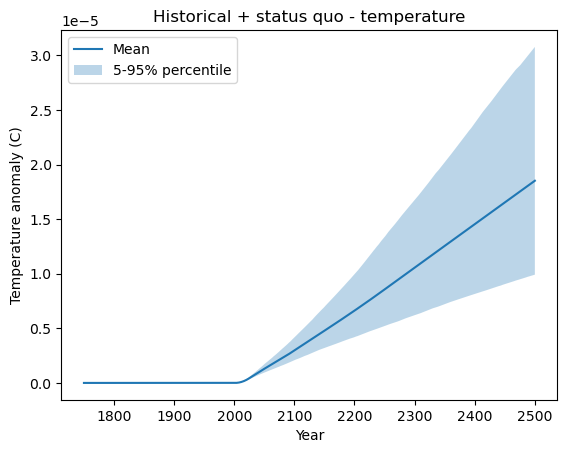

In [18]:
# First experiment plots: History + status quo as defined in ../data/emissions/anesthesics_gas_emissions(based on Talbot NO adjustment).csv

mean_f_status_q_tiva_temperature = (f_status_q_tiva_temperature - f_no_anesthesics_temperature).mean(dim='config')
p05_f_status_q_tiva_temperature = (f_status_q_tiva_temperature - f_no_anesthesics_temperature).quantile(0.05, dim='config')
p95_f_status_q_tiva_temperature = (f_status_q_tiva_temperature - f_no_anesthesics_temperature).quantile(0.95, dim='config')

# For diagnosis purposes, just plot these emissions timeseries
timebounds = np.arange(1750,2500,1)
timebounds_1 = np.arange(1750,2501,1)
plt.plot(timebounds, emissions_1_status_q_tiva[:, 0, 0], label="HFE-236ea2")
plt.plot(timebounds, emissions_2_status_q_tiva[:, 0, 0], label="HFE-347mmz1")
plt.plot(timebounds, emissions_3_status_q_tiva[:, 0, 0], label="HCFE-235da2")
plt.plot(timebounds, emissions_4_status_q_tiva[:, 0, 0], label="Halon-2311")
plt.title('Historical + status quo - emissions')
plt.ylabel('Emissions (kt/year)')
plt.legend()
plt.show()

plt.plot(timebounds, TIVA_emissions_status_q_tiva)
plt.title('Historical + status quo - emissions CO2')
plt.ylabel('Emissions (GtCO2/year)')
plt.show()

# Plot the mean with a shaded area for 5-95 percentile
plt.plot(timebounds_1, mean_f_status_q_tiva_temperature, label='Mean')
plt.fill_between(timebounds_1, p05_f_status_q_tiva_temperature, p95_f_status_q_tiva_temperature, alpha=0.3, label='5-95% percentile')

plt.title('Historical + status quo - temperature')
plt.xlabel('Year')
plt.ylabel('Temperature anomaly (C)')
plt.legend()
plt.show()


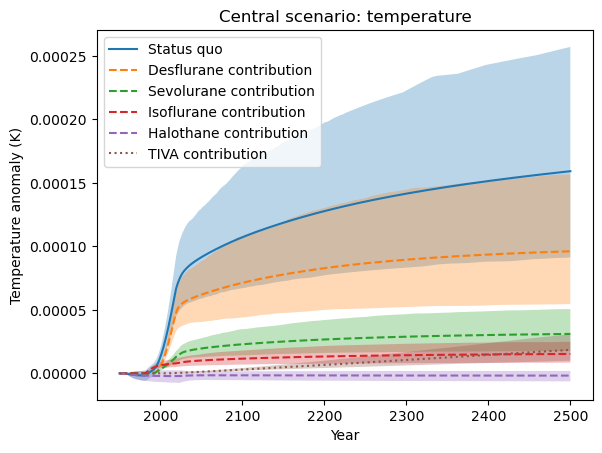

In [31]:
# Now plotting the total status quo scenario with all the components

initial_year = 1950 - 1750

plt.plot(timebounds_1[initial_year:], mean_f_status_quo_temperature[initial_year:], label='Status quo')
plt.fill_between(timebounds_1[initial_year:], p05_f_status_quo_temperature[initial_year:], p95_f_status_quo_temperature[initial_year:], alpha=0.3)

# Desflurane contribution
plt.plot(timebounds_1[initial_year:], mean_f_status_q_desflurane_temperature[initial_year:], label='Desflurane contribution', linestyle='--')
plt.fill_between(timebounds_1[initial_year:], p05_f_status_q_desflurane_temperature[initial_year:], p95_f_status_q_desflurane_temperature[initial_year:], alpha=0.3)

# Sevoflurane contribution
plt.plot(timebounds_1[initial_year:], mean_f_status_q_sevo_temperature[initial_year:], label='Sevolurane contribution', linestyle='--')
plt.fill_between(timebounds_1[initial_year:], p05_f_status_q_sevo_temperature[initial_year:], p95_f_status_q_sevo_temperature[initial_year:], alpha=0.3)

# Isolurane contribution
plt.plot(timebounds_1[initial_year:], mean_f_status_q_iso_temperature[initial_year:], label='Isoflurane contribution', linestyle='--')
plt.fill_between(timebounds_1[initial_year:], p05_f_status_q_iso_temperature[initial_year:], p95_f_status_q_iso_temperature[initial_year:], alpha=0.3)

# Halothane contribution
plt.plot(timebounds_1[initial_year:], mean_f_status_q_halo_temperature[initial_year:], label='Halothane contribution', linestyle='--')
plt.fill_between(timebounds_1[initial_year:], p05_f_status_q_halo_temperature[initial_year:], p95_f_status_q_halo_temperature[initial_year:], alpha=0.3)

# TIVA contribution
plt.plot(timebounds_1[initial_year:], mean_f_status_q_tiva_temperature[initial_year:], label='TIVA contribution', linestyle=':')
plt.fill_between(timebounds_1[initial_year:], p05_f_status_q_tiva_temperature[initial_year:], p95_f_status_q_tiva_temperature[initial_year:], alpha=0.3)



plt.title('Central scenario: temperature')
plt.xlabel('Year')
plt.ylabel('Temperature anomaly (K)')
plt.legend()
plt.show()

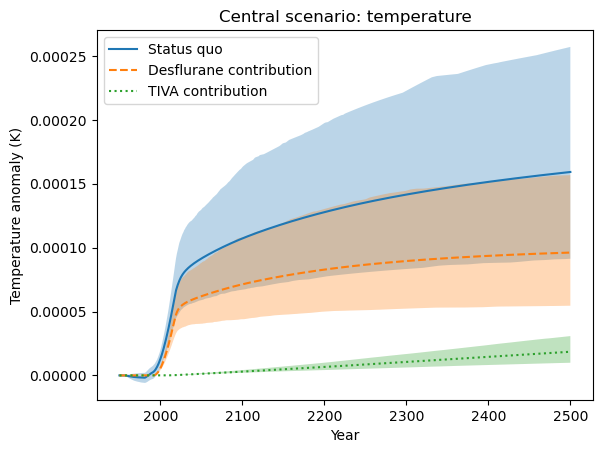

In [32]:
# Now plotting the total status quo scenario with with only the desflurane and TIVA components

initial_year = 1950 - 1750

plt.plot(timebounds_1[initial_year:], mean_f_status_quo_temperature[initial_year:], label='Status quo')
plt.fill_between(timebounds_1[initial_year:], p05_f_status_quo_temperature[initial_year:], p95_f_status_quo_temperature[initial_year:], alpha=0.3)

# Desflurane contribution
plt.plot(timebounds_1[initial_year:], mean_f_status_q_desflurane_temperature[initial_year:], label='Desflurane contribution', linestyle='--')
plt.fill_between(timebounds_1[initial_year:], p05_f_status_q_desflurane_temperature[initial_year:], p95_f_status_q_desflurane_temperature[initial_year:], alpha=0.3)

# TIVA contribution
plt.plot(timebounds_1[initial_year:], mean_f_status_q_tiva_temperature[initial_year:], label='TIVA contribution', linestyle=':')
plt.fill_between(timebounds_1[initial_year:], p05_f_status_q_tiva_temperature[initial_year:], p95_f_status_q_tiva_temperature[initial_year:], alpha=0.3)



plt.title('Central scenario: temperature')
plt.xlabel('Year')
plt.ylabel('Temperature anomaly (K)')
plt.legend()
plt.show()